# AST 384C - Computational Astrophysics - HW 3
## Carlos Jurado

In [1]:
# Python package imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt 

# Loading in style file for plots
plt.style.use('/Users/caj3577/Desktop/plotting.mplstyle')

# Problem 1: Non-Gaussian Samplers

Problem 9 From Hogg & Foreman-Mackey (2018): 

Modify the sampler you wrote in Problem 2 to take steps not in x but in lnx . That is, replace the Gaussian proposal distribution q x x ¢( ∣ ) with a Gaussian distribution in xlnq x x ln ln¢( ∣ ), but make no other changes. By doing this, you are no longer sampling the Gaussian p(x)that you were in Problem 2. What about your answers changes? What distribution are you sampling now? Compute the analytic function that you have sampled from—this will no longer be the same p(x) and overplot it on your histogram. The solution to this problem is shown in Figure 4.

#### Motivation For Code Setup

Suppose I let $y=lnx$, then $x=e^y$ and $\frac{dx}{dy} = e^y$, then following the rules of probability and transformations:

$$
\begin{align*}
P_{Y}(y)dy = P_{X}(x)dx \\
P_{Y}(y) = P_{X}(x)\frac{dx}{dy} \\
P_{Y}(y) = P_{X}(x)e^y
\end{align*}
$$
In Problem 2 we had the standard form of the gaussian : $$P_{X}(x) =  \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(x-\mu)^2}{2\sigma^2}}$$

We can get a similiar distribution for $P_{X}(y)$ by subsitutiing $e^y$ in for $x$:
$$
\begin{align*}
P_{X}(x) = \frac{P_{Y}(y)}{e^y} = \frac{1}{e^y \sqrt{2\pi\sigma^2}}e^{\frac{-(x-\mu)^2}{2\sigma^2}} \\
P_{Y}(y) = e^y \frac{1}{e^y \sqrt{2\pi\sigma^2}}e^{\frac{-(x-\mu)^2}{2\sigma^2}} = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(x-\mu)^2}{2\sigma^2}}
\end{align*}
$$
Thus, in y(log)-space, $P_{Y}(y)$ is a normal distribution in y. 

I can approach this problem by using my code from Problem 2, exactly as is, but with the assumption that we are working in log space. Then to go to linear space, I will need to do $x=e^y$ to all of my samples. This is the equivalent of, anywhere where there was an x in my code, replacing with y, and then expotentiating the samples at the end of the mcmc.

(0.0, 20.0)

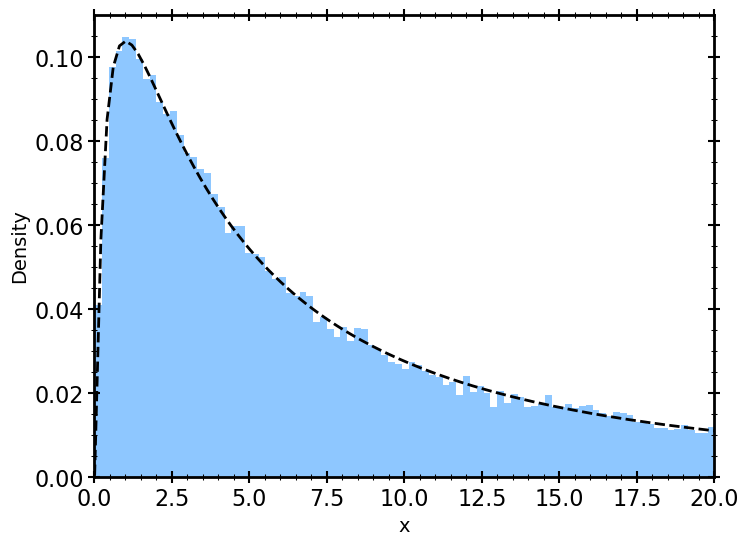

In [2]:
#y = lnx
def target_log(y, mean=2, sigma=np.sqrt(2)):
    ''' 
    Gaussian target function that we wish to sample from 

    Parameters
        y: Current value 
        mean: Mean value of the gaussian
        sigma: Standard deviation of the gaussian 

    returns: float value

    '''
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5* (y-mean)**2/(sigma**2))

def proposal(y):
    '''  
    Proposal distribution from which to sample a new point from given the current point

    Parameters
        y: Current position 

    returns: float value
    
    '''
    return random.normal(y, 1)

def acceptance_ratio(y, y_new):
    return target_log(y_new)/target_log(y)

def mcmc_logspace(y0, n_samples):
    y_samples = np.zeros(n_samples)  # Initializes a fixed numpy array
    y_samples[0] = y0 # Assigns the starting value as the first value in the chain
    for i in range(1, n_samples):
        y_new = proposal(y_samples[i-1])  # proposes a new value based on the current location
        uni = random.uniform(0, 1) # sample one point from a uniform distribution
        if acceptance_ratio(y_samples[i-1], y_new) > uni:  # Metropolis-Hastings Implementation
            y_samples[i] = y_new
        else:
            y_samples[i] = y_samples[i-1]
    return y_samples

y0 = 0.0 
n_samples = 100000
y_samples = mcmc_logspace(y0, n_samples)

# Transform back to linear space
samples = np.exp(y_samples)

# Plotting
x_vals = np.linspace(0.01, 200, 1000)
mu, sigma = 2, np.sqrt(2)
analytical_lognorm = (1 / (x_vals * sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((np.log(x_vals) - mu)**2 / sigma**2))

plt.hist(samples, bins=12000, density=True, alpha=0.5, color='dodgerblue')
plt.plot(x_vals, analytical_lognorm, color='black', lw=2, linestyle='--')
plt.xlabel('x')
plt.ylabel('Density')
plt.xlim(0,20)

In linear space, I am no longer sampling from a gaussian but from a log-normal gaussian distribution. This is seen with how the analytical equation (dashed black curve) aligns with the mcmc samples.

# Problem 2: Convergence

Do problem 10 from Hogg & Foreman-Mackey (2018): Redo Problem 2, but now look at convergence: 

Plot the x chain as a function of time step. Also split the chain into four contiguous segments (the first, second, third, and fourth quarters of the chain). In each of these four, compute the empirical mean and empirical variance of x. What do you conclude about convergence from these heuristics?

In [3]:
######################################################  Code For Problem 2 Begins Here #################################### 

def target(x, mean=2, sigma=np.sqrt(2) ):
    ''' 
    Gaussian target function that we wish to sample from 

    Parameters
        x: Current value 
        mean: Mean value of the gaussian
        sigma: Standard deviation of the gaussian 

    returns: float value

    '''
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5* (x-mean)**2/(sigma**2))

def proposal(x,sigma):
    '''  
    Proposal distribution from which to sample a new point from given the current point

    Parameters
        x: Current position 

    returns: float value
    
    '''
    return random.normal(x,sigma)

def acceptance_ratio(x, x_new):
    return target(x_new)/target(x)

def mcmc(x0, n_samples, sigma=1):
    samples = np.zeros(n_samples) # Initializes a fixed numpy array 
    samples[0] = x0 # Assigns the starting value as the first value in the chain
    for i in range(1, n_samples):
        x_new = proposal(samples[i-1], sigma) # proposes a new value based on the current location
        uni = random.uniform(0, 1) # sample one point from a uniform distribution
        if acceptance_ratio(samples[i-1], x_new) > uni: # Metropolis-Hastings Implementation
            samples[i] = x_new
        else:
            samples[i] = samples[i-1]
    return samples

x0 = 0
n_samples = 100000
samples_var1 = mcmc(x0, n_samples)
######################################################  Code For Problem 2 Ends Here #################################### 

Text(0, 0.5, 'x')

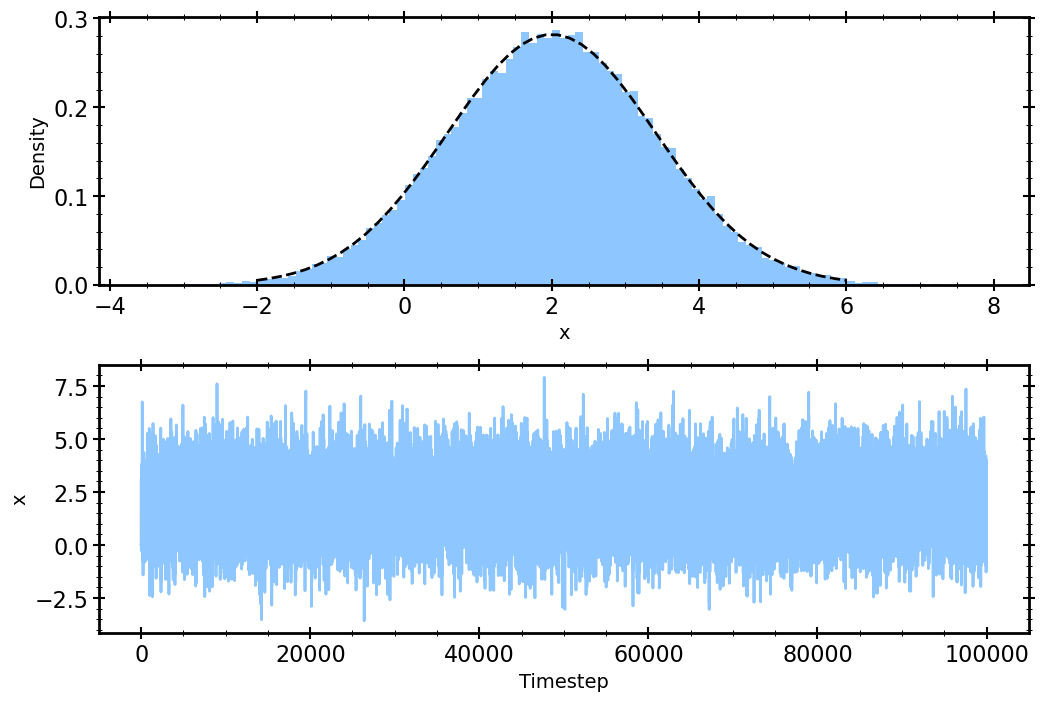

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.3)

x=np.linspace(-2,6)
axs[0].hist(samples_var1, color='dodgerblue', alpha=0.5, bins='scott', density=True, lw=2)
axs[0].plot(x, target(x), color='black', lw=2, linestyle = '--')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Density')

axs[1].plot(samples_var1, color='dodgerblue', alpha=0.5)
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('x')

In [5]:
quarter = 25000

intervals_arr = [samples_var1[0:quarter], samples_var1[quarter:2*quarter], 
                 samples_var1[2*quarter:3*quarter], samples_var1[3*quarter:]]

i = 1
for arr in intervals_arr:
    print(f'\nMean of quarter {i} is: {np.round(np.mean(arr),2)} ')
    print(f'Variance of quarter {i} is: {np.round(np.var(arr),2)} ')
    print('=====================================')
    i += 1


Mean of quarter 1 is: 2.0 
Variance of quarter 1 is: 1.95 

Mean of quarter 2 is: 2.03 
Variance of quarter 2 is: 2.02 

Mean of quarter 3 is: 1.99 
Variance of quarter 3 is: 2.01 

Mean of quarter 4 is: 2.03 
Variance of quarter 4 is: 1.94 


The values of the mean and variance for the quarters suggest that even with only 25,000 steps, the mcmc converges on the true mean and variance values of the distribution function. 

# Problem 3: Autocorrelation
Do problem 11 from Hogg & Foreman-Mackey. Repeat the exercise using a proposal distribution that has a variance two times larger, and again with a variance that is two times smaller than what is given in the original problem. How does the autocorrelation function change (and why)?

Problem 11. Write a piece of code that computes the empirical
autocorrelation function. You will probably want to speed this
computation up by using a fast Fourier transform.37 Run this on
the chain you obtained from Problem 2. Plot the autocorrelation
function you find at short lags (Δ<100). This plot should
resemble Figure 5

#### Motivation For Code Setup

From Wikipeida, "For a discrete process with known mean and variance for which we observe n observations $ \{X_1, X_2,..., X_n\}$, an estimate of the autocorrelation coefficient may be obtained as":

$$ 
R(k) = \frac{1}{(n-k)\sigma^2} \sum_{t=1}^{n-k} (X_t - \mu)(X_{t+k} +\mu)
$$

where k is the lag, $\mu$ is the mean, and $\sigma$ is the variance. 

The Wiener-Khinchin theorem states that the autocorrelation function of a stationary time series is the inverse fourier transform of its power spectral density. The power spectral density is just the squared magnitude of the original fourier transform. Therefore, I can calculate the autocorrelation function directly from the fourier transform. 


In [6]:
samples_var2 = mcmc(x0, n_samples,sigma=2)
samples_varhalf = mcmc(x0, n_samples,sigma=0.5)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


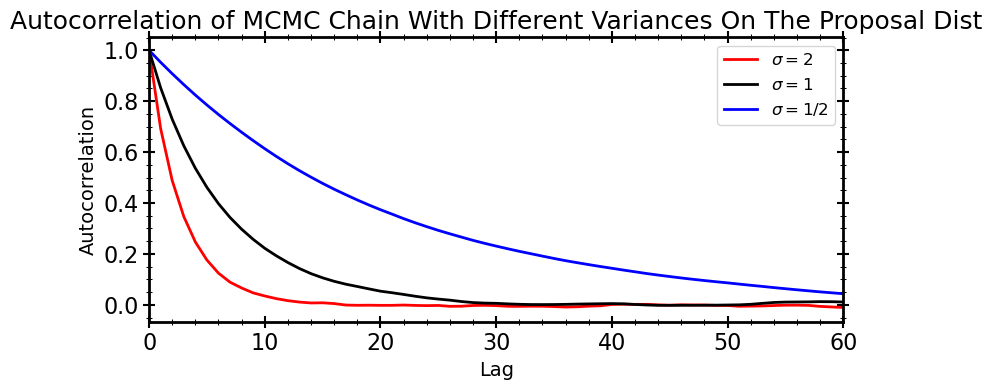

In [7]:
def autocorrelation(samples):
    ''' 
    Calculates the autocorrelation function from MCMC samples using FFTs

    Parameters:
        - val: An array of MCMC samples

    Returns: (array)
    '''

    samples -= np.mean(samples) #centering the sample. This avoids an issue where the autocorrelation function asymptotes at a value above zero 
    fft = np.fft.fft(samples) #calculates the fourier transform of the mcmc samples
    power_spectrum = fft * np.conjugate(fft) # computes the power spectrum
    autocorrelation_function = np.fft.ifft(power_spectrum) # calculates the inverse fourier transform of the power spectrum

    return autocorrelation_function



# Calculate and plot ACF
autocorrelation_values_var2 = autocorrelation(samples_var2)
acv_normalized_var2 = autocorrelation_values_var2/autocorrelation_values_var2[0] #normalization

autocorrelation_values_var1 = autocorrelation(samples_var1)
acv_normalized_var1 = autocorrelation_values_var1/autocorrelation_values_var1[0] #normalization

autocorrelation_values_varhalf = autocorrelation(samples_varhalf)
acv_normalized_varhalf = autocorrelation_values_varhalf/autocorrelation_values_varhalf[0] #normalization

plt.figure(figsize=(8, 4))
plt.plot(acv_normalized_var2[:100], color = 'red', linewidth=2, label=r'$\sigma = 2$') 
plt.plot(acv_normalized_var1[:100], color = 'black', linewidth=2, label=r'$\sigma = 1$') 
plt.plot(acv_normalized_varhalf[:100], color = 'blue', linewidth=2, label=r'$\sigma = 1/2$') 
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of MCMC Chain With Different Variances On The Proposal Dist")
plt.tight_layout()
plt.xlim(0,60)
plt.legend()


From the above plot, as the variance increases, the autocorrelation function decreasess more rapidly. This is because at higher variances, the chain explores large areas more quickly and so each new sample is more likely to be far from the previous sample and to be uncorrelated with each other. At high variance, the chain is able to more quickly explore areas of parameter space and lose memory quicker of it's starting point. This is not the case when the variance is lower because each new sample stays relatively close to each other, increasing the probability of correlation between the two points.